<a href="https://colab.research.google.com/github/map72ru/biz_learn/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install razdel

In [2]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 8.2MB 6.1MB/s 


In [15]:
from google.colab import drive
drive.mount('/content/hw2')

Mounted at /content/hw2


In [16]:
!ls hw2/MyDrive

 7851L_Mihailov_AP.doc	    Backup	       data     temp
 7851L_Mihailov_APOut.pdf  'Colab Notebooks'   Devops


In [17]:
import pandas as pd

In [19]:
news = pd.read_csv("hw2/MyDrive/data/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [20]:
users = pd.read_csv("hw2/MyDrive/data/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [21]:
#from gensim.test.utils import common_texts
# https://webdevblog.ru/gensim-rukovodstvo-dlya-nachinajushhih/
from gensim.corpora.dictionary import Dictionary

In [22]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [25]:
stopword_ru = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

In [26]:
len(stopword_ru)

151

In [28]:
with open('hw2/MyDrive/data/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [29]:
stopword_ru[-1]

'thru'

In [30]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub("n", ' ', text)

    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    #print(tokens)
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
                #print(temp_cach)
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
                #print(w,' : ',temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    #print(words_lem_without_stopwords)
    return words_lem_without_stopwords

In [31]:
list(tokenize(news.iloc[0,1][:100],   ))

[Substring(0, 11, 'Заместитель'),
 Substring(12, 24, 'председателя'),
 Substring(24, 25, 'n'),
 Substring(25, 38, 'правительства'),
 Substring(39, 41, 'РФ'),
 Substring(41, 42, 'n'),
 Substring(42, 48, 'Сергей'),
 Substring(48, 49, 'n'),
 Substring(49, 55, 'Иванов'),
 Substring(55, 56, 'n'),
 Substring(56, 62, 'избран'),
 Substring(63, 76, 'председателем'),
 Substring(77, 83, 'совета'),
 Substring(83, 84, 'n'),
 Substring(84, 87, 'ПБК'),
 Substring(88, 92, 'ЦСКА'),
 Substring(92, 93, 'n'),
 Substring(93, 94, '.'),
 Substring(95, 98, 'Как'),
 Substring(99, 100, 'с')]

In [32]:
norm_text = news.iloc[:2,1].apply(lambda x: clean_text(x), 1)
norm_text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [33]:
lemmatization(norm_text[0])

['заместитель',
 'председатель',
 'правительство',
 'рф',
 'сергей',
 'иванов',
 'избрать',
 'председатель',
 'совет',
 'пбк',
 'цска',
 'прессслужба',
 'армеец',
 'решение',
 'единогласно',
 'принять',
 'первый',
 'заседание',
 'совет',
 'клуб',
 'основной',
 'функция',
 'орган',
 'обсуждение',
 'текущий',
 'состояние',
 'планирование',
 'утверждение',
 'стратегия',
 'развитие',
 'клуб',
 'близкий',
 'перспектива',
 'состав',
 'совет',
 'войти',
 'георгий',
 'полтавченко',
 'полномочный',
 'центральный',
 'федеральный',
 'округ',
 'алексей',
 'седов',
 'генералполковник',
 'начальник',
 'служба',
 'защита',
 'конституционный',
 'строй',
 'борьба',
 'терроризм',
 'фсб',
 'рф',
 'александр',
 'новак',
 'заместитель',
 'министр',
 'финансы',
 'рф',
 'вячеслав',
 'полтавец',
 'заместитель',
 'генеральный',
 'директор',
 'руководитель',
 'блок',
 'взаимодействие',
 'орган',
 'власть',
 'социальный',
 'корпоративный',
 'политика',
 'гмк',
 'норильский',
 'никель',
 'леонид',
 'исакович',
 '

In [34]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 25.3 s, sys: 2.15 s, total: 27.5 s
Wall time: 27.5 s


In [35]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 1s, sys: 716 ms, total: 4min 2s
Wall time: 4min 2s


In [36]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [37]:
common_dictionary[4]

'банк'

In [38]:
common_dictionary.id2token

{0: 'александр',
 1: 'алексей',
 2: 'андрей',
 3: 'армеец',
 4: 'банк',
 5: 'баскетбол',
 6: 'близкий',
 7: 'блок',
 8: 'борьба',
 9: 'ватутин',
 10: 'взаимодействие',
 11: 'власть',
 12: 'войти',
 13: 'вячеслав',
 14: 'генералполковник',
 15: 'генеральный',
 16: 'георгий',
 17: 'гмк',
 18: 'директор',
 19: 'европа',
 20: 'единогласно',
 21: 'заместитель',
 22: 'заседание',
 23: 'защита',
 24: 'иванов',
 25: 'избрать',
 26: 'исакович',
 27: 'клиентский',
 28: 'клуб',
 29: 'конституционный',
 30: 'корпоративный',
 31: 'леонид',
 32: 'лопат',
 33: 'министр',
 34: 'мир',
 35: 'начальник',
 36: 'никель',
 37: 'новак',
 38: 'норильский',
 39: 'оао',
 40: 'обсуждение',
 41: 'округ',
 42: 'ольга',
 43: 'ооо',
 44: 'орган',
 45: 'основной',
 46: 'пбк',
 47: 'первый',
 48: 'перспектива',
 49: 'планирование',
 50: 'плешаков',
 51: 'политика',
 52: 'полномочный',
 53: 'полтавец',
 54: 'полтавченко',
 55: 'правительство',
 56: 'правление',
 57: 'председатель',
 58: 'прессслужба',
 59: 'принять',
 

In [39]:
common_dictionary.doc2bow(['баскетбол' ,'баскетбол' ,'наше', 'все'], allow_update=True)

[(5, 2), (135645, 1), (135646, 1)]

In [40]:
common_corpus[0][0]

(0, 2)

In [41]:
len(texts[0])

113

In [42]:
N_topic = 10 # число тем - гиперпараметр

In [43]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

CPU times: user 34 s, sys: 6.21 s, total: 40.2 s
Wall time: 33.4 s


In [44]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [45]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(3, 0.11247601), (7, 0.21995454), (9, 0.6500658)]

In [46]:
x=lda.show_topics(num_topics=N_topic, num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: россия москва глава российский вопрос закон ребёнок крым решение пенсия день рак депутат квартира женщина
topic_1: учёный всё исследование рост большой уровень первый гражданин новый ребёнок риск очень жизнь мозг проблема
topic_2: учёный исследователь научный фонд земля исследование область турист ребёнок смерть место тыс день обнаружить первый
topic_3: млн тыс составить руб рынок стоимость доллар журнал банк ставка составлять ген общий новый продажа
topic_4: ракета космический первый орбита животное взрыв произойти планета солнечный asa вода запуск торговый самолёт пациент
topic_5: погибнуть тело убийство египет мужчина следователь фильм космонавт инвестиция восток ссср бомба юг днк второй
topic_6: россия российский сша военный газ система власть новый сторона глава территория американский данные санкция рф
topic_7: украина украинский россия население научный всё поверхность новый банк эксперт журнал иметь киев метод мнение
topic_8: млрд рубль самолёт российский нефть корабль

In [47]:
news['title'].iloc[5]

['ио',
 'главное',
 'тренер',
 'вячеслав',
 'буцай',
 'прокомментировать',
 'победа',
 'югра',
 'матч',
 'регулярный',
 'чемпионат',
 'кхл',
 'прежде',
 'хотеть',
 'поблагодарить',
 'ребята',
 'команда',
 'передавать',
 'официальный',
 'сайт',
 'югра',
 'игра',
 'начинаться',
 'очень',
 'удачно',
 'пропустить',
 'гол',
 'первый',
 'смена',
 'долго',
 'входить',
 'игра',
 'связать',
 'дневный',
 'матч',
 'непривычный',
 'плюс',
 'третий',
 'матч',
 'сибирь',
 'гдеть',
 'ребята',
 'чувствовать',
 'скажем',
 'сонный',
 'второй',
 'третий',
 'период',
 'показать',
 'разбежаться',
 'играть',
 'правильно',
 'появиться',
 'момент',
 'дотерпеть',
 'заслуженно',
 'победить']

In [48]:
lda[common_dictionary.doc2bow(news['title'].iloc[1])]

[(2, 0.071633846), (4, 0.72358), (9, 0.18770944)]

In [49]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [50]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.433208,0.104059,0.0,0.456592
1,4896,0.0,0.000000,0.071495,0.000000,0.723603,0.000000,0.000000,0.000000,0.0,0.187826
2,4897,0.0,0.000000,0.000000,0.112425,0.000000,0.000000,0.000000,0.219963,0.0,0.650108
3,4898,0.0,0.551132,0.000000,0.000000,0.000000,0.000000,0.143582,0.296747,0.0,0.000000
4,4899,0.0,0.000000,0.000000,0.000000,0.000000,0.155336,0.823038,0.000000,0.0,0.000000


In [51]:
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.433208,0.104059,0.0,0.456592
1,4896,0.0,0.000000,0.071495,0.000000,0.723603,0.000000,0.000000,0.000000,0.0,0.187826
2,4897,0.0,0.000000,0.000000,0.112425,0.000000,0.000000,0.000000,0.219963,0.0,0.650108
3,4898,0.0,0.551132,0.000000,0.000000,0.000000,0.000000,0.143582,0.296747,0.0,0.000000
4,4899,0.0,0.000000,0.000000,0.000000,0.000000,0.155336,0.823038,0.000000,0.0,0.000000


In [52]:
users.head(10)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"
5,u106662,"[323868, 323426, 324267, 322426, 324104, 1550]"
6,u105949,"[293138, 294471, 295012, 294736, 293949, 3544]"
7,u102457,"[6928, 5009, 6940, 7629, 7644, 512736]"
8,u104124,"[322838, 324699, 322991, 322120, 324327, 472331]"
9,u101386,"[7827, 6427, 7394, 7151, 6335, 487254]"


In [53]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [54]:
doc_dict[293622]

array([0.42314684, 0.08787167, 0.11541931, 0.20994736, 0.02397312,
       0.        , 0.        , 0.        , 0.03560435, 0.10084502])

In [84]:
def get_user_embedding(user_articles_list, func):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    return func(user_vector, 0)

In [86]:
user_articles_list = users['articles'].iloc[33]

In [89]:
vv = get_user_embedding(user_articles_list, np.median)
vv

array([0.12725607, 0.05181215, 0.        , 0.        , 0.        ,
       0.00741662, 0.22836957, 0.        , 0.0559657 , 0.        ])

In [90]:
vv = get_user_embedding(user_articles_list, np.max)
vv

array([0.69631517, 0.2023423 , 0.        , 0.06486122, 0.11404415,
       0.08809845, 0.78144181, 0.20341466, 0.56250238, 0.20025888])

In [91]:
vv = get_user_embedding(user_articles_list, np.mean)
vv

array([0.2729555 , 0.07625022, 0.        , 0.0108102 , 0.03489695,
       0.03057027, 0.29780372, 0.05142085, 0.18297953, 0.03337648])

In [92]:
import matplotlib.pyplot as plt

In [93]:
target = pd.read_csv("hw2/MyDrive/data/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
precision_recall_curve, confusion_matrix, recall_score
import itertools

%matplotlib inline
methods = dict({'max': np.max, 'median': np.median, 'mean': np.mean})

In [95]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
    font = {'size' : 15}

    plt.rc('font', **font)

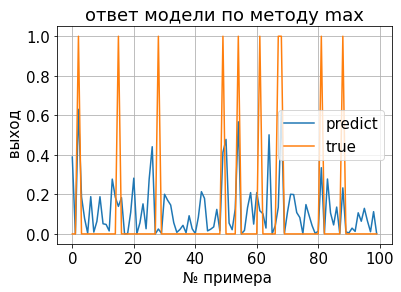

Method: max. Best Threshold=0.219256, F-Score=0.461, Precision=0.374, Recall=0.598


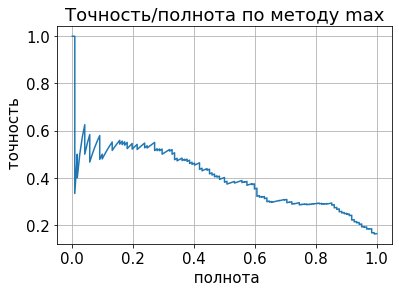

Confusion matrix, without normalization
[[1508  247]
 [  90  155]]


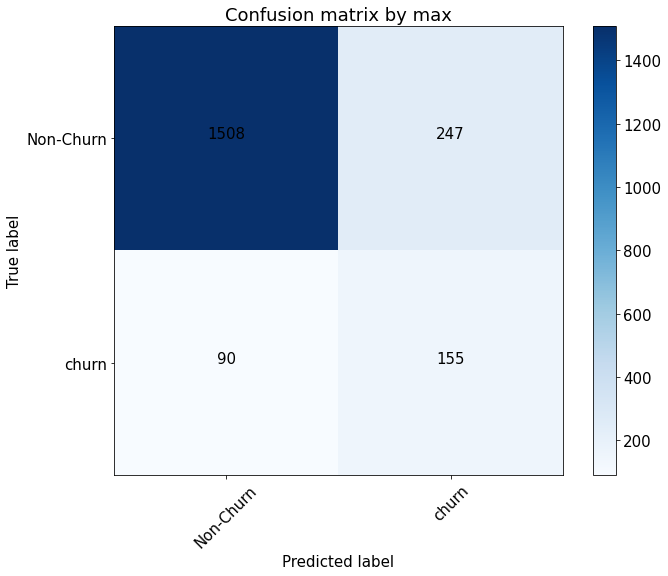

0.8472725158439444


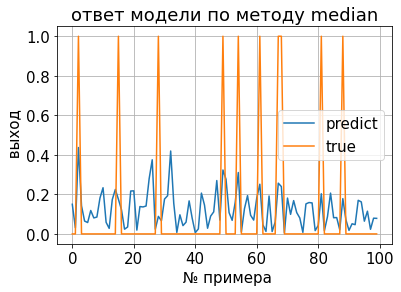

Method: median. Best Threshold=0.171651, F-Score=0.458, Precision=0.332, Recall=0.738


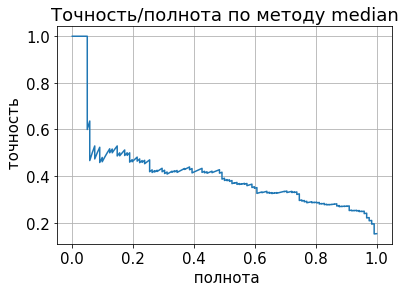

Confusion matrix, without normalization
[[1406  349]
 [  65  180]]


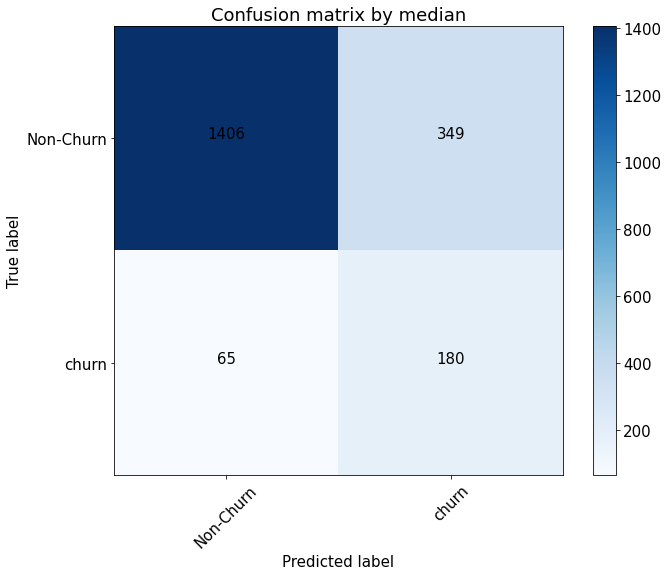

0.8539217396360254


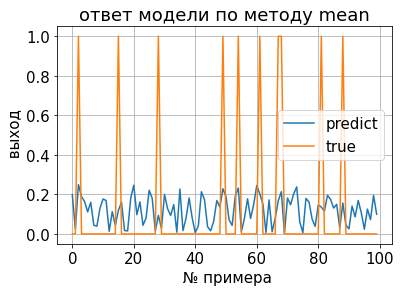

Method: mean. Best Threshold=0.312974, F-Score=nan, Precision=0.000, Recall=0.000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


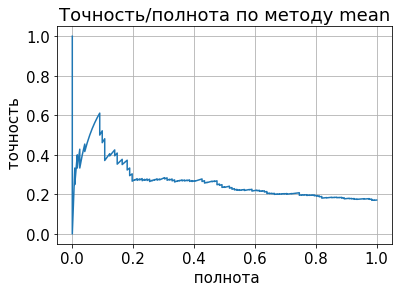

Confusion matrix, without normalization
[[1752    3]
 [ 245    0]]


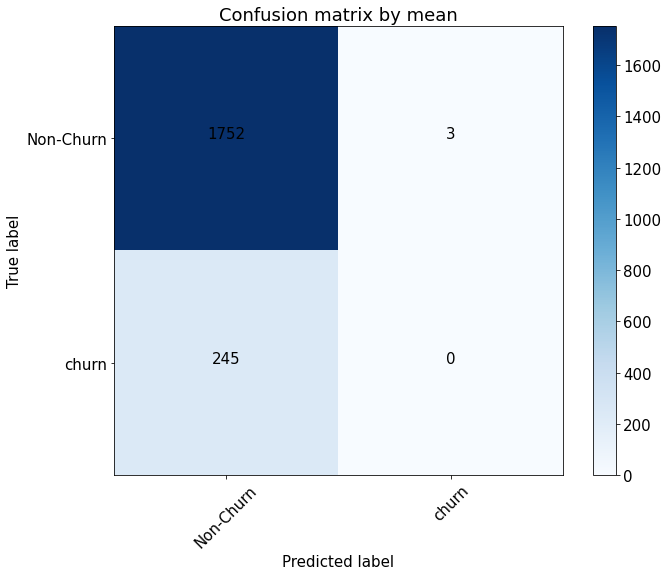

0.7426431769288911


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [123]:
result = dict()
for method in methods.keys():
  user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, methods[method]), 1)])
  user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
  user_embeddings['uid'] = users['uid'].values
  user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
  X = pd.merge(user_embeddings, target, 'left')

  #разделим данные на train/test
  X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, test_size=0.25)
  
  logreg = LogisticRegression(C=1.0)
  #обучим наш пайплайн
  logreg.fit(X_train, y_train)
  preds = logreg.predict_proba(X_test)[:, 1]

  plt.plot(preds[:100], label = 'predict')
  plt.plot(y_test.values[:100], label = 'true')
  plt.title(f'ответ модели по методу {method}')
  plt.xlabel(' № примера')
  plt.ylabel(' выход')
  plt.legend()
  plt.grid('On')
  plt.show()


  precision, recall, thresholds = precision_recall_curve(y_test.values[:1000], preds[:1000])

  fscore = (2 * precision * recall) / (precision + recall)

  r =  roc_auc_score(y_test, preds)

# locate the index of the largest f score
  ix = np.argmax(fscore)
  print('Method: %s. Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' 
          % (method, thresholds[ix], fscore[ix], precision[ix], recall[ix]))
  plt.plot(recall,precision )
  plt.title(f'Точность/полнота по методу {method}')
  plt.xlabel(' полнота')
  plt.ylabel(' точность')
  plt.grid('On')
  plt.show()

  cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
  plt.figure(figsize=(10, 8))
  plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title=f'Confusion matrix by {method}')
  plt.show()
  
  predict = logreg.predict(X_test)

  result[method] = dict({'precision': precision_score(y_test.values, predict), 
                         'recall': recall_score(y_test.values, predict), 
                         'fscore': f1_score(y_test.values, predict),
                         'roc': r})
  print(r)



In [124]:
result

{'max': {'fscore': 0.22149837133550487,
  'precision': 0.5483870967741935,
  'recall': 0.13877551020408163,
  'roc': 0.8472725158439444},
 'mean': {'fscore': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'roc': 0.7426431769288911},
 'median': {'fscore': 0.00806451612903226,
  'precision': 0.3333333333333333,
  'recall': 0.004081632653061225,
  'roc': 0.8539217396360254}}

Лучший результат дает использование медианы при расчете эмбедингов.
